# **Task 1: Defining your Problem and Audience**

Users of the King James Bible lack an intelligent, context-aware way to search, explore, and understand biblical content across books, chapters, and themes.

### **Problem Context and Target Audience**

The target user is a Bible Study Leader, Theology Student, or Christian Educator who regularly engages with Scripture for research, teaching, or sermon preparation.

These users often ask nuanced or multi-faceted questions such as:

+ "Where does the Bible talk about forgiveness across the Old and New Testaments?"
+ "Which verses describe God’s mercy using similar language?"
+ "Can you compare how love is portrayed in Psalms vs. in Paul's letters?"

Currently, they rely on keyword-based search or manual reading, which:

+ Fails to capture semantic meaning or cross-book relationships
+ Is time-consuming, especially when preparing thematic studies
+ Lacks a structured, intelligent interface for exploration or summarization

By automating semantic search, cross-referencing, and thematic summarization, we can drastically improve how these users interact with Scripture — making Bible study more efficient, insightful, and personalized.

# **Task 2: Propose a Solution**

### **Proposed Solution & User Experience**

We propose building an **Agentic RAG-powered Bible Explorer**: an interactive semantic search and summarization tool for users to ask complex, open-ended questions about the Bible and receive coherent, faith-aligned, multi-verse responses.

The user interface will feel like a chat with an “AI Bible Scholar.” A Bible Study Leader can ask:

> *“Where does the Bible talk about God’s promises during times of despair?”*

The system will retrieve semantically relevant verses across books, apply agentic reasoning to group and summarize them into themes (e.g., “Hope in Psalms,” “Faith in Hebrews”), and present the output in an interpretable format — optionally citing verse locations and summaries.

Users will save **hours of manual cross-referencing**, gain **deep thematic insight**, and improve the quality of their lessons or sermons.


### **Tools and Architecture Stack**

| Layer                   | Tool                                    | Rationale                                                                              |
| ----------------------- | --------------------------------------- | -------------------------------------------------------------------------------------- |
| **LLM**                 | `gpt-4.1`                               | High performance in language generation, handles abstract religious themes with nuance |
| **Embedding Model**     | `text-embedding-3-small`                | Accurate, fast, OpenAI-supported, and highly cost-effective                            |
| **Orchestration**       | `LangGraph`                             | Ideal for agentic reasoning and stateful multi-step retrieval/summarization            |
| **Vector DB**           | `Qdrant`                                | Fast, production-ready, with robust metadata filtering (e.g., by book, chapter)        |
| **Monitoring**          | `LangSmith`                             | Essential for traceable observability and debugging of RAG flows                       |
| **Evaluation**          | `RAGAS`                                 | Standard for retrieval-based evaluation (faithfulness, precision, relevance, etc.)     |
| **UI**                  | `Chainlit`                              | Streamlined UI for multi-turn semantic chat, markdown-friendly and developer-friendly  |
| **Serving & Inference** | `FastAPI + Docker + Hugging Face Space` | Reliable, scalable, and community-shareable deployment setup                           |


### **Agent Usage and Agentic Reasoning**

We will integrate **two LangGraph-based agents**:

1. **Query Decomposition Agent** – breaks down multi-part queries like:

   > *"What does Jesus say about prayer in the Gospels, and how is it applied in the Epistles?"*

   Into:

   * Sub-query 1: *“What does Jesus say about prayer in the Gospels?”*
   * Sub-query 2: *“How is prayer discussed in the Epistles?”*

2. **Summarization Agent** – interprets retrieved verses, clusters them by semantic meaning or book, and summarizes the findings using chain-of-thought prompting.

Agentic reasoning allows contextual memory, thematic consistency, and accurate mapping of scriptural concepts across Testaments — far beyond traditional keyword search.

# **Task 3: Dealing with the Data**

### **Data Pre-processing**

In [1]:
import pandas as pd

from config import settings

# Load KJV Data
kjv_df = pd.read_csv(f"./data/{settings.DATASET_PREFIX}.tsv", sep="\\t", skiprows=2, names=["Reference", "Text"])

# Special book names
special_books = [
    'Song of Solomon', '1 Kings', '2 Kings', '1 Samuel', '2 Samuel',
    '1 Chronicles', '2 Chronicles', '1 Corinthians', '2 Corinthians',
    '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy',
    '1 Peter', '2 Peter', '1 John', '2 John', '3 John'
]

def preprocess_reference(ref):
    for book in special_books:
        if ref.startswith(book):
            remaining = ref[len(book):].strip()
            return pd.Series([book, remaining])
    return pd.Series(ref.split(' ', 1))

# Preprocess
kjv_df[['Book', 'ChapterVerse']] = kjv_df['Reference'].apply(preprocess_reference)
kjv_df[['Chapter', 'Verse']] = kjv_df['ChapterVerse'].str.split(':', n=1, expand=True)
kjv_df['Chapter'] = kjv_df['Chapter'].astype(int)
kjv_df['Verse'] = kjv_df['Verse'].astype(int)

# Drop redundant columns
kjv_df.drop(columns=['ChapterVerse', 'Reference'], inplace=True)
kjv_df.to_csv(f"./data/{settings.DATASET_PREFIX}_preprocessed.csv", index=False)

kjv_df.sample(10)

/var/folders/g_/16x28wss4bz5_7h7pmt9w29h0000gn/T/ipykernel_9244/1512769297.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  kjv_df = pd.read_csv(f"./data/{settings.DATASET_PREFIX}.tsv", sep="\\t", skiprows=2, names=["Reference", "Text"])


,Text,Book,Chapter,Verse
16535,Let thy fountain be blessed: and rejoice with ...,Proverbs,5,18
12646,"The Levites in the days of Eliashib, Joiada, a...",Nehemiah,12,22
27363,Now there were in the church that was at Antio...,Acts,13,1
6615,"But Barak pursued after the chariots, and afte...",Judges,4,16
7822,"Then said David, Will the men of Keilah delive...",1 Samuel,23,12
1651,And the officers of the children of Israel did...,Exodus,5,19
19376,Thus said the LORD unto me; Go and stand in th...,Jeremiah,17,19
24553,"And straightway all the people, when they behe...",Mark,9,15
15401,[Nor] for the pestilence [that] walketh in dar...,Psalm,91,6
49,And out of the ground the LORD God formed ever...,Genesis,2,19


### **Data Sources and External APIs**

| Source / API                                          | Purpose                                                                                                                                                                                         |
| ----------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`kjv_preprocessed.csv`**                            | Core knowledge base of biblical content. Each row includes `Text`, `Book`, `Chapter`, and `Verse`, allowing semantic indexing and metadata filtering.                                           |
| **Tavily Search API**                                 | For agent-initiated internet augmentation (e.g., cross-referencing external theological commentaries, definitions, or historical context). Used as a fallback for missing or ambiguous context. |
| **OpenAI APIs (`gpt-4.1`, `text-embedding-3-small`)** | Language generation and semantic embedding for both retrieval and agent reasoning.                                                                                                              |
| **LangSmith**                                         | Observability and debugging of multi-agent reasoning chains.                                                                                                                                    |
| **RAGAS**                                             | Evaluation of the RAG pipeline using metrics like **Faithfulness**, **Answer Relevance**, **Context Precision**, and **Context Recall**.                                                        |


### **Default Chunking Strategy**

#### **Strategy**: *Semantic Chunking with Context-Aware Merging*

* **Step 1**: Start with verse-level entries as base units (each row in `kjv_preprocessed.csv`)
* **Step 2**: Group **2–5 adjacent verses** together if:

  * They share the same `Book` and `Chapter`
  * They form a logical thematic unit (measured via cosine similarity threshold ≥ 0.8 between embeddings)
* **Step 3**: Ensure the resulting chunk is ≤ 256 tokens for efficient embedding

#### **Why This Strategy?**

* Verse-level granularity is too small for meaningful semantic search.
* Chapter-level is often too broad or diluted.
* Grouping adjacent verses allows richer semantic context while preserving theological integrity and referential clarity.
* This also improves **context recall** and **faithfulness** in downstream RAG outputs, which is critical in religious settings where misinterpretation must be avoided.


# **Task 4 — Baseline Embeddings and RAGAS evaluation**

In [1]:
import os
import pandas as pd

from pathlib import Path

from config import settings

from embed.chunking import chunk_verses
from embed.embeddings import get_openai_embedding_model
from embed.qdrant_vectorstore import create_qdrant_vectorstore

from core.ragas_evaluator import evaluate_ragas
from pipeline.rag_chain import build_rag_chain, print_rag_response
from pipeline.golden_testset_generator import generate_golden_testset

CACHE_DIR = Path(f"cache/{settings.DATASET_PREFIX}")
CACHE_DIR.mkdir(exist_ok=True)

def save_df(df, name: str):
    df.to_csv(CACHE_DIR / f"{name}.csv", index=False)

def load_df(name: str):
    path = CACHE_DIR / f"{name}.csv"
    return pd.read_csv(path) if path.exists() else None

def run_baseline_phase():
    # Load CSV
    print(f"Loading {settings.DATASET_PREFIX}_preprocessed.csv")
    df = pd.read_csv(f"./data/{settings.DATASET_PREFIX}_preprocessed.csv")

    # Chunk verses
    print("Chunking verses...")
    chunked_docs = chunk_verses(df=df)
    print(f"Number of chunked docs: {len(chunked_docs)}")

    # Save documents to cache
    print("Saving chunked docs...")
    save_df(pd.DataFrame(chunked_docs), "chunked_docs")

    # Embed and ingest
    print("Embedding and ingesting...")
    vectorstore = create_qdrant_vectorstore(
        documents=chunked_docs,
        embedding_model=get_openai_embedding_model(),
        collection_name=settings.COLLECTION_NAME_BASELINE,
        vector_dim=settings.VECTOR_DIM_BASELINE
    )

    print("Building RAG pipeline...")
    rag_graph = build_rag_chain(vectorstore)

    print("Executing RAG pipeline...Query 1")
    print_rag_response(rag_graph.invoke({"query": "Where does the Bible talk about forgiveness across the Old and New Testaments?"}))

    print("Executing RAG pipeline...Query 2")
    print_rag_response(rag_graph.invoke({"query": "Can you compare how love is portrayed in Psalms vs. in Paul's letters?"}))

    # Generate Golden Testset
    golden_testset_df = None
    if not os.path.exists(CACHE_DIR / "golden_testset.csv"):
        print("Generating Golden Testset...")
        golden_testset_df = generate_golden_testset(chunked_docs)
        save_df(golden_testset_df, "golden_testset")
    else:
        print("Loading golden testset...")
        golden_testset_df = load_df("golden_testset")

    # Run testset through RAG pipeline
    # and evaluate baseline RAGAS
    print("RAGAS Evaluation (baseline)...")
    eval_df = evaluate_ragas(golden_testset_df, rag_graph)
    save_df(eval_df, "baseline_metrics")

run_baseline_phase()

Loading kjv_preprocessed.csv
Chunking verses...
Number of chunked docs: 4409
Saving chunked docs...
Embedding and ingesting...
Length of langchain_docs: 4409
Qdrant collection 'kjv_verse_chunks' already exists — loading it.
Building RAG pipeline...
Executing RAG pipeline...Query 1


───────────────────────────────────────────────── Bible Explorer ──────────────────────────────────────────────────

Main Query: Where does the Bible talk about forgiveness across the Old and New Testaments?

Sub-Questions:

1. Where does the Old Testament talk about forgiveness?

2. Where does the New Testament talk about forgiveness?

───────────────────────────── 🔍 Where does the Old Testament talk about forgiveness? ─────────────────────────────

1 Kings 8:33-40

When thy people Israel be smitten down before the enemy, because they have sinned against thee, and shall turn 
again to thee, and confess thy name, and pray, and make supplication unto thee in this house: Then hear thou in 
heaven, and forgive the sin of thy people Israel, and bring them again unto the land which thou gavest unto their 
fathers. When heaven is shut up, and there is no rain, because they have sinned against thee; if they pray toward 
this place, and confess thy name, and turn from their sin, when thou afflictest them: Then hear thou in heaven, and
forgive the sin of thy servants, and of thy people Israel, that thou teach them the good way wherein they should 
walk, and give rain upon thy land, which thou hast given to thy people for an inheritance. If there be in the land 
famine, if there be pestilence, blasting, mildew, locust,  if there be caterpiller; if their enemy besiege them in 
the land of their cities; whatsoever plague, whatsoever sickness ; What prayer and supplication soever be  by any 
man,  by all thy people Israel, which shall know every man the plague of his own heart, and spread forth his hands 
toward this house: Then hear thou in heaven thy dwelling place, and forgive, and do, and give to every man 
according to his ways, whose heart thou knowest; (for thou,  thou only, knowest the hearts of all the children of 
men;) That they may fear thee all the days that they live in the land which thou gavest unto our fathers.

Leviticus 6:1-8

And the LORD spake unto Moses, saying, If a soul sin, and commit a trespass against the LORD, and lie unto his 
neighbour in that which was delivered him to keep, or in fellowship, or in a thing taken away by violence, or hath 
deceived his neighbour; Or have found that which was lost, and lieth concerning it, and sweareth falsely; in any of
all these that a man doeth, sinning therein: Then it shall be, because he hath sinned, and is guilty, that he shall
restore that which he took violently away, or the thing which he hath deceitfully gotten, or that which was 
delivered him to keep, or the lost thing which he found, Or all that about which he hath sworn falsely; he shall 
even restore it in the principal, and shall add the fifth part more thereto,  give it unto him to whom it 
appertaineth, in the day of his trespass offering. And he shall bring his trespass offering unto the LORD, a ram 
without blemish out of the flock, with thy estimation, for a trespass offering, unto the priest: And the priest 
shall make an atonement for him before the LORD: and it shall be forgiven him for any thing of all that he hath 
done in trespassing therein. And the LORD spake unto Moses, saying,

Numbers 14:17-24

And now, I beseech thee, let the power of my Lord be great, according as thou hast spoken, saying, The LORD  
longsuffering, and of great mercy, forgiving iniquity and transgression, and by no means clearing , visiting the 
iniquity of the fathers upon the children unto the third and fourth . Pardon, I beseech thee, the iniquity of this 
people according unto the greatness of thy mercy, and as thou hast forgiven this people, from Egypt even until now.
And the LORD said, I have pardoned according to thy word: But  truly  I live, all the earth shall be filled with 
the glory of the LORD. Because all those men which have seen my glory, and my miracles, which I did in Egypt and in
the wilderness, and have tempted me now these ten times, and have not hearkened to my voice; Surely they shall not 
see the land which I sware unto their fathers, neither shall any of them that provoked me see it: But my servant 
Caleb, because he had another spirit with him, and hath followed me fully, him will I bring into the land whereinto
he went; and his seed shall possess it.

Micah 7:17-20

They shall lick the dust like a serpent, they shall move out of their holes like worms of the earth: they shall be 
afraid of the LORD our God, and shall fear because of thee. Who  a God like unto thee, that pardoneth iniquity, and
passeth by the transgression of the remnant of his heritage? he retaineth not his anger for ever, because he 
delighteth  mercy. He will turn again, he will have compassion upon us; he will subdue our iniquities; and thou 
wilt cast all their sins into the depths of the sea. Thou wilt perform the truth to Jacob,  the mercy to Abraham, 
which thou hast sworn unto our fathers from the days of old.

Numbers 5:1-8

And the LORD spake unto Moses, saying, Command the children of Israel, that they put out of the camp every leper, 
and every one that hath an issue, and whosoever is defiled by the dead: Both male and female shall ye put out, 
without the camp shall ye put them; that they defile not their camps, in the midst whereof I dwell. And the 
children of Israel did so, and put them out without the camp: as the LORD spake unto Moses, so did the children of 
Israel. And the LORD spake unto Moses, saying, Speak unto the children of Israel, When a man or woman shall commit 
any sin that men commit, to do a trespass against the LORD, and that person be guilty; Then they shall confess 
their sin which they have done: and he shall recompense his trespass with the principal thereof, and add unto it 
the fifth  thereof, and give  unto  against whom he hath trespassed. But if the man have no kinsman to recompense 
the trespass unto, let the trespass be recompensed unto the LORD,  to the priest; beside the ram of the atonement, 
whereby an atonement shall be made for him.

───────────────────────────── 🔍 Where does the New Testament talk about forgiveness? ─────────────────────────────

Luke 5:17-24

And it came to pass on a certain day, as he was teaching, that there were Pharisees and doctors of the law sitting 
by, which were come out of every town of Galilee, and Judaea, and Jerusalem: and the power of the Lord was  to heal
them. And, behold, men brought in a bed a man which was taken with a palsy: and they sought  to bring him in, and 
to lay  before him. And when they could not find by what  they might bring him in because of the multitude, they 
went upon the housetop, and let him down through the tiling with  couch into the midst before Jesus. And when he 
saw their faith, he said unto him, Man, thy sins are forgiven thee. And the scribes and the Pharisees began to 
reason, saying, Who is this which speaketh blasphemies? Who can forgive sins, but God alone? But when Jesus 
perceived their thoughts, he answering said unto them, What reason ye in your hearts? Whether is easier, to say, 
Thy sins be forgiven thee; or to say, Rise up and walk? But that ye may know that the Son of man hath power upon 
earth to forgive sins, (he said unto the sick of the palsy,) I say unto thee, Arise, and take up thy couch, and go 
into thine house.

Luke 7:41-48

There was a certain creditor which had two debtors: the one owed five hundred pence, and the other fifty. And when 
they had nothing to pay, he frankly forgave them both. Tell me therefore, which of them will love him most? Simon 
answered and said, I suppose that , to whom he forgave most. And he said unto him, Thou hast rightly judged. And he
turned to the woman, and said unto Simon, Seest thou this woman? I entered into thine house, thou gavest me no 
water for my feet: but she hath washed my feet with tears, and wiped  with the hairs of her head. Thou gavest me no
kiss: but this woman since the time I came in hath not ceased to kiss my feet. My head with oil thou didst not 
anoint: but this woman hath anointed my feet with ointment. Wherefore I say unto thee, Her sins, which are many, 
are forgiven; for she loved much: but to whom little is forgiven,  loveth little. And he said unto her, Thy sins 
are forgiven.

Romans 5:9-16

Much more then, being now justified by his blood, we shall be saved from wrath through him. For if, when we were 
enemies, we were reconciled to God by the death of his Son, much more, being reconciled, we shall be saved by his 
life. And not only , but we also joy in God through our Lord Jesus Christ, by whom we have now received the 
atonement. Wherefore, as by one man sin entered into the world, and death by sin; and so death passed upon all men,
for that all have sinned: (For until the law sin was in the world: but sin is not imputed when there is no law. 
Nevertheless death reigned from Adam to Moses, even over them that had not sinned after the similitude of Adam’s 
transgression, who is the figure of him that was to come. But not as the offence, so also  the free gift. For if 
through the offence of one many be dead, much more the grace of God, and the gift by grace,  by one man, Jesus 
Christ, hath abounded unto many. And not as  by one that sinned,  the gift: for the judgment  by one to 
condemnation, but the free gift  of many offences unto justification.

1 John 1:9-10

If we confess our sins, he is faithful and just to forgive us  sins, and to cleanse us from all unrighteousness. If
we say that we have not sinned, we make him a liar, and his word is not in us.

Hebrews 10:17-24

And their sins and iniquities will I remember no more. Now where remission of these  no more offering for sin. 
Having therefore, brethren, boldness to enter into the holiest by the blood of Jesus, By a new and living way, 
which he hath consecrated for us, through the veil, that is to say, his flesh; And  an high priest over the house 
of God; Let us draw near with a true heart in full assurance of faith, having our hearts sprinkled from an evil 
conscience, and our bodies washed with pure water. Let us hold fast the profession of  faith without wavering; (for
he  faithful that promised;) And let us consider one another to provoke unto love and to good works:

───────────────────────────────────────────────── 🧠 Final Answer ─────────────────────────────────────────────────

Certainly! The retrieved verses naturally cluster into several thematic groups and book-based clusters, which      
center around sin, confession, forgiveness, atonement, mercy, and restoration in both the Old and New Testament    
contexts. Here is a detailed chain-of-thought summary organized by themes and scriptural contexts:                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              1. Old Testament Instructions on Sin, Confession, and Forgiveness (Torah/Law of Moses)               

 • Theme: Covenant relationship, rebellion, punishment, repentance, and God's mercy.                               
 • Verses:                                                                                                         
    • 2 Chronicles 6:21-31 (Solomon’s prayer at the dedication of the temple): Israel’s collective sin leads to    
      suffering (defeat, famine, plague), yet if they repent, confess God’s name, and pray toward the temple, God  
      will hear, forgive, and restore them to their land, showing that God’s forgiveness is conditional on         
      repentance and heartfelt supplication.                                                                       
    • Leviticus 5:20-26, 6:1-7 (Laws of restitution and trespass offerings): Individual sins, especially those     
      involving deceit or theft, require restitution plus a fifth part, and a trespass offering to obtain          
      forgiveness. The process of confession and atonement maintains covenant purity.                              
    • Numbers 14:17-24 (Moses intercedes for Israel): Highlights God's patience and mercy in withholding immediate 
      judgment for Israel's rebelliousness, yet warns of consequences for persistent disobedience—promising        
      eventual pardon upon repentance, but also exile from the promised land for hardened hearts.                  
    • Micah 7:17-20 (Prophetic declaration of mercy): God pardons iniquity, does not retain anger forever, delights
      in mercy, and casts sin "into the depths of the sea," reaffirming the Old Testament motif of repentance and  
      divine forgiveness.                                                                                          
    • Leviticus 13:45-46 (Purity laws): Command to isolate lepers and unclean persons from the camp to maintain    
      holiness, symbolizing communal consequences of sin and the need for separation until cleansing.              

Summary:                                                                                                           
In the Old Testament, sin disrupts Israel’s covenant relationship with God and brings physical, social, and        
spiritual consequences. The prescribed response is sincere confession, restitution, and offerings, to restore both 
individual and communal fellowship with God. God’s character, however, is patient and merciful, willing to forgive 
upon repentance but not clearing the guilty unrepentant, emphasizing a justice tempered by mercy.                  

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               2. New Testament Teachings on Forgiveness, Faith, and Atonement through Jesus Christ                

 • Theme: Jesus’ authority to forgive, love stemming from forgiveness, justification through Christ’s sacrifice,   
   and ongoing confession for cleansing and renewal.                                                               
 • Verses:                                                                                                         
    • Luke 5:17-24 (Healing of the paralytic and forgiveness of sins): Jesus demonstrates divine authority to      
      forgive sins—a prerogative of God alone—thereby linking physical healing with spiritual forgiveness, and     
      revealing the Son of Man’s power to restore w

Executing RAG pipeline...Query 2


───────────────────────────────────────────────── Bible Explorer ──────────────────────────────────────────────────

Main Query: Can you compare how love is portrayed in Psalms vs. in Paul's letters?

Sub-Questions:

1. How is love portrayed in the book of Psalms?

2. How is love portrayed in Paul's letters?

3. What are the similarities in the portrayal of love between Psalms and Paul's letters?

4. What are the differences in the portrayal of love between Psalms and Paul's letters?

───────────────────────────────── 🔍 How is love portrayed in the book of Psalms? ─────────────────────────────────

Psalm 138:1-8

[A Psalm] of David. I will praise thee with my whole heart: before the gods will I sing praise unto thee. I will 
worship toward thy holy temple, and praise thy name for thy lovingkindness and for thy truth: for thou hast 
magnified thy word above all thy name. In the day when I cried thou answeredst me,  strengthenedst me  strength in 
my soul. All the kings of the earth shall praise thee, O LORD, when they hear the words of thy mouth. Yea, they 
shall sing in the ways of the LORD: for great  the glory of the LORD. Though the LORD  high, yet hath he respect 
unto the lowly: but the proud he knoweth afar off. Though I walk in the midst of trouble, thou wilt revive me: thou
shalt stretch forth thine hand against the wrath of mine enemies, and thy right hand shall save me. The LORD will 
perfect  concerneth me: thy mercy, O LORD,  for ever: forsake not the works of thine own hands.

Psalm 108:1-8

A Song  Psalm of David. O God, my heart is fixed; I will sing and give praise, even with my glory. Awake, psaltery 
and harp: I  will awake early. I will praise thee, O LORD, among the people: and I will sing praises unto thee 
among the nations. For thy mercy  great above the heavens: and thy truth  unto the clouds. Be thou exalted, O God, 
above the heavens: and thy glory above all the earth; That thy beloved may be delivered: save  thy right hand, and 
answer me. God hath spoken in his holiness; I will rejoice, I will divide Shechem, and mete out the valley of 
Succoth. Gilead  mine; Manasseh  mine; Ephraim also  the strength of mine head; Judah  my lawgiver;

Psalm 28:1-8

[A Psalm] of David. Unto thee will I cry, O LORD my rock; be not silent to me: lest,  thou be silent to me, I 
become like them that go down into the pit. Hear the voice of my supplications, when I cry unto thee, when I lift 
up my hands toward thy holy oracle. Draw me not away with the wicked, and with the workers of iniquity, which speak
peace to their neighbours, but mischief  in their hearts. Give them according to their deeds, and according to the 
wickedness of their endeavours: give them after the work of their hands; render to them their desert. Because they 
regard not the works of the LORD, nor the operation of his hands, he shall destroy them, and not build them up. 
Blessed  the LORD, because he hath heard the voice of my supplications. The LORD  my strength and my shield; my 
heart trusted in him, and I am helped: therefore my heart greatly rejoiceth; and with my song will I praise him. 
The LORD  their strength, and he  the saving strength of his anointed.

Psalm 63:1-8

A Psalm of David, when he was in the wilderness of Judah. O God, thou  my God; early will I seek thee: my soul 
thirsteth for thee, my flesh longeth for thee in a dry and thirsty land, where no water is; To see thy power and 
thy glory, so  I have seen thee in the sanctuary. Because thy lovingkindness  better than life, my lips shall 
praise thee. Thus will I bless thee while I live: I will lift up my hands in thy name. My soul shall be satisfied 
as  marrow and fatness; and my mouth shall praise  with joyful lips: When I remember thee upon my bed,  meditate on
thee in the  watches. Because thou hast been my help, therefore in the shadow of thy wings will I rejoice. My soul 
followeth hard after thee: thy right hand upholdeth me.

Psalm 30:1-8

A Psalm  Song  the dedication of the house of David. I will extol thee, O LORD; for thou hast lifted me up, and 
hast not made my foes to rejoice over me. O LORD my God, I cried unto thee, and thou hast healed me. O LORD, thou 
hast brought up my soul from the grave: thou hast kept me alive, that I should not go down to the pit. Sing unto 
the LORD, O ye saints of his, and give thanks at the remembrance of his holiness. For his anger  a moment; in his 
favour  life: weeping may endure for a night, but joy  in the morning. And in my prosperity I said, I shall never 
be moved. LORD, by thy favour thou hast made my mountain to stand strong: thou didst hide thy face,  I was 
troubled. I cried to thee, O LORD; and unto the LORD I made supplication.

─────────────────────────────────── 🔍 How is love portrayed in Paul's letters? ───────────────────────────────────

2 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the will of God, according to the promise of life which is in Christ Jesus, To 
Timothy,  dearly beloved son: Grace, mercy,  peace, from God the Father and Christ Jesus our Lord. I thank God, 
whom I serve from  forefathers with pure conscience, that without ceasing I have remembrance of thee in my prayers 
night and day; Greatly desiring to see thee, being mindful of thy tears, that I may be filled with joy; When I call
to remembrance the unfeigned faith that is in thee, which dwelt first in thy grandmother Lois, and thy mother 
Eunice; and I am persuaded that in thee also. Wherefore I put thee in remembrance that thou stir up the gift of 
God, which is in thee by the putting on of my hands. For God hath not given us the spirit of fear; but of power, 
and of love, and of a sound mind. Be not thou therefore ashamed of the testimony of our Lord, nor of me his 
prisoner: but be thou partaker of the afflictions of the gospel according to the power of God;

Philemon 1:1-8

Paul, a prisoner of Jesus Christ, and Timothy  brother, unto Philemon our dearly beloved, and fellowlabourer, And 
to  beloved Apphia, and Archippus our fellowsoldier, and to the church in thy house: Grace to you, and peace, from 
God our Father and the Lord Jesus Christ. I thank my God, making mention of thee always in my prayers, Hearing of 
thy love and faith, which thou hast toward the Lord Jesus, and toward all saints; That the communication of thy 
faith may become effectual by the acknowledging of every good thing which is in you in Christ Jesus. For we have 
great joy and consolation in thy love, because the bowels of the saints are refreshed by thee, brother. Wherefore, 
though I might be much bold in Christ to enjoin thee that which is convenient,

Colossians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timotheus  brother, To the saints and faithful brethren in
Christ which are at Colosse: Grace  unto you, and peace, from God our Father and the Lord Jesus Christ. We give 
thanks to God and the Father of our Lord Jesus Christ, praying always for you, Since we heard of your faith in 
Christ Jesus, and of the love  to all the saints, For the hope which is laid up for you in heaven, whereof ye heard
before in the word of the truth of the gospel; Which is come unto you, as  in all the world; and bringeth forth 
fruit, as  also in you, since the day ye heard , and knew the grace of God in truth: As ye also learned of Epaphras
our dear fellowservant, who is for you a faithful minister of Christ; Who also declared unto us your love in the 
Spirit.

1 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the commandment of God our Saviour, and Lord Jesus Christ,  our hope; Unto 
Timothy,  own son in the faith: Grace, mercy,  peace, from God our Father and Jesus Christ our Lord. As I besought 
thee to abide still at Ephesus, when I went into Macedonia, that thou mightest charge some that they teach no other
doctrine, Neither give heed to fables and endless genealogies, which minister questions, rather than godly edifying
which is in faith: . Now the end of the commandment is charity out of a pure heart, and  a good conscience, and  
faith unfeigned: From which some having swerved have turned aside unto vain jangling; Desiring to be teachers of 
the law; understanding neither what they say, nor whereof they affirm. But we know that the law  good, if a man use
it lawfully;

Ephesians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, to the saints which are at Ephesus, and to the faithful in 
Christ Jesus: Grace  to you, and peace, from God our Father, and  the Lord Jesus Christ. Blessed  the God and 
Father of our Lord Jesus Christ, who hath blessed us with all spiritual blessings in heavenly  in Christ: According
as he hath chosen us in him before the foundation of the world, that we should be holy and without blame before him
in love: Having predestinated us unto the adoption of children by Jesus Christ to himself, according to the good 
pleasure of his will, To the praise of the glory of his grace, wherein he hath made us accepted in the beloved. In 
whom we have redemption through his blood, the forgiveness of sins, according to the riches of his grace; Wherein 
he hath abounded toward us in all wisdom and prudence;

──────────── 🔍 What are the similarities in the portrayal of love between Psalms and Paul's letters? ─────────────

2 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the will of God, according to the promise of life which is in Christ Jesus, To 
Timothy,  dearly beloved son: Grace, mercy,  peace, from God the Father and Christ Jesus our Lord. I thank God, 
whom I serve from  forefathers with pure conscience, that without ceasing I have remembrance of thee in my prayers 
night and day; Greatly desiring to see thee, being mindful of thy tears, that I may be filled with joy; When I call
to remembrance the unfeigned faith that is in thee, which dwelt first in thy grandmother Lois, and thy mother 
Eunice; and I am persuaded that in thee also. Wherefore I put thee in remembrance that thou stir up the gift of 
God, which is in thee by the putting on of my hands. For God hath not given us the spirit of fear; but of power, 
and of love, and of a sound mind. Be not thou therefore ashamed of the testimony of our Lord, nor of me his 
prisoner: but be thou partaker of the afflictions of the gospel according to the power of God;

Philemon 1:1-8

Paul, a prisoner of Jesus Christ, and Timothy  brother, unto Philemon our dearly beloved, and fellowlabourer, And 
to  beloved Apphia, and Archippus our fellowsoldier, and to the church in thy house: Grace to you, and peace, from 
God our Father and the Lord Jesus Christ. I thank my God, making mention of thee always in my prayers, Hearing of 
thy love and faith, which thou hast toward the Lord Jesus, and toward all saints; That the communication of thy 
faith may become effectual by the acknowledging of every good thing which is in you in Christ Jesus. For we have 
great joy and consolation in thy love, because the bowels of the saints are refreshed by thee, brother. Wherefore, 
though I might be much bold in Christ to enjoin thee that which is convenient,

Colossians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timotheus  brother, To the saints and faithful brethren in
Christ which are at Colosse: Grace  unto you, and peace, from God our Father and the Lord Jesus Christ. We give 
thanks to God and the Father of our Lord Jesus Christ, praying always for you, Since we heard of your faith in 
Christ Jesus, and of the love  to all the saints, For the hope which is laid up for you in heaven, whereof ye heard
before in the word of the truth of the gospel; Which is come unto you, as  in all the world; and bringeth forth 
fruit, as  also in you, since the day ye heard , and knew the grace of God in truth: As ye also learned of Epaphras
our dear fellowservant, who is for you a faithful minister of Christ; Who also declared unto us your love in the 
Spirit.

1 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the commandment of God our Saviour, and Lord Jesus Christ,  our hope; Unto 
Timothy,  own son in the faith: Grace, mercy,  peace, from God our Father and Jesus Christ our Lord. As I besought 
thee to abide still at Ephesus, when I went into Macedonia, that thou mightest charge some that they teach no other
doctrine, Neither give heed to fables and endless genealogies, which minister questions, rather than godly edifying
which is in faith: . Now the end of the commandment is charity out of a pure heart, and  a good conscience, and  
faith unfeigned: From which some having swerved have turned aside unto vain jangling; Desiring to be teachers of 
the law; understanding neither what they say, nor whereof they affirm. But we know that the law  good, if a man use
it lawfully;

2 Corinthians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timothy  brother, unto the church of God which is at 
Corinth, with all the saints which are in all Achaia: Grace  to you and peace from God our Father, and  the Lord 
Jesus Christ. Blessed  God, even the Father of our Lord Jesus Christ, the Father of mercies, and the God of all 
comfort; Who comforteth us in all our tribulation, that we may be able to comfort them which are in any trouble, by
the comfort wherewith we ourselves are comforted of God. For as the sufferings of Christ abound in us, so our 
consolation also aboundeth by Christ. And whether we be afflicted,  for your consolation and salvation, which is 
effectual in the enduring of the same sufferings which we also suffer: or whether we be comforted,  for your 
consolation and salvation. And our hope of you  stedfast, knowing, that as ye are partakers of the sufferings, so  
also of the consolation. For we would not, brethren, have you ignorant of our trouble which came to us in Asia, 
that we were pressed out of measure, above strength, insomuch that we despaired even of life:

───────────── 🔍 What are the differences in the portrayal of love between Psalms and Paul's letters? ─────────────

2 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the will of God, according to the promise of life which is in Christ Jesus, To 
Timothy,  dearly beloved son: Grace, mercy,  peace, from God the Father and Christ Jesus our Lord. I thank God, 
whom I serve from  forefathers with pure conscience, that without ceasing I have remembrance of thee in my prayers 
night and day; Greatly desiring to see thee, being mindful of thy tears, that I may be filled with joy; When I call
to remembrance the unfeigned faith that is in thee, which dwelt first in thy grandmother Lois, and thy mother 
Eunice; and I am persuaded that in thee also. Wherefore I put thee in remembrance that thou stir up the gift of 
God, which is in thee by the putting on of my hands. For God hath not given us the spirit of fear; but of power, 
and of love, and of a sound mind. Be not thou therefore ashamed of the testimony of our Lord, nor of me his 
prisoner: but be thou partaker of the afflictions of the gospel according to the power of God;

1 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the commandment of God our Saviour, and Lord Jesus Christ,  our hope; Unto 
Timothy,  own son in the faith: Grace, mercy,  peace, from God our Father and Jesus Christ our Lord. As I besought 
thee to abide still at Ephesus, when I went into Macedonia, that thou mightest charge some that they teach no other
doctrine, Neither give heed to fables and endless genealogies, which minister questions, rather than godly edifying
which is in faith: . Now the end of the commandment is charity out of a pure heart, and  a good conscience, and  
faith unfeigned: From which some having swerved have turned aside unto vain jangling; Desiring to be teachers of 
the law; understanding neither what they say, nor whereof they affirm. But we know that the law  good, if a man use
it lawfully;

Philemon 1:1-8

Paul, a prisoner of Jesus Christ, and Timothy  brother, unto Philemon our dearly beloved, and fellowlabourer, And 
to  beloved Apphia, and Archippus our fellowsoldier, and to the church in thy house: Grace to you, and peace, from 
God our Father and the Lord Jesus Christ. I thank my God, making mention of thee always in my prayers, Hearing of 
thy love and faith, which thou hast toward the Lord Jesus, and toward all saints; That the communication of thy 
faith may become effectual by the acknowledging of every good thing which is in you in Christ Jesus. For we have 
great joy and consolation in thy love, because the bowels of the saints are refreshed by thee, brother. Wherefore, 
though I might be much bold in Christ to enjoin thee that which is convenient,

Colossians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timotheus  brother, To the saints and faithful brethren in
Christ which are at Colosse: Grace  unto you, and peace, from God our Father and the Lord Jesus Christ. We give 
thanks to God and the Father of our Lord Jesus Christ, praying always for you, Since we heard of your faith in 
Christ Jesus, and of the love  to all the saints, For the hope which is laid up for you in heaven, whereof ye heard
before in the word of the truth of the gospel; Which is come unto you, as  in all the world; and bringeth forth 
fruit, as  also in you, since the day ye heard , and knew the grace of God in truth: As ye also learned of Epaphras
our dear fellowservant, who is for you a faithful minister of Christ; Who also declared unto us your love in the 
Spirit.

Ephesians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, to the saints which are at Ephesus, and to the faithful in 
Christ Jesus: Grace  to you, and peace, from God our Father, and  the Lord Jesus Christ. Blessed  the God and 
Father of our Lord Jesus Christ, who hath blessed us with all spiritual blessings in heavenly  in Christ: According
as he hath chosen us in him before the foundation of the world, that we should be holy and without blame before him
in love: Having predestinated us unto the adoption of children by Jesus Christ to himself, according to the good 
pleasure of his will, To the praise of the glory of his grace, wherein he hath made us accepted in the beloved. In 
whom we have redemption through his blood, the forgiveness of sins, according to the riches of his grace; Wherein 
he hath abounded toward us in all wisdom and prudence;

───────────────────────────────────────────────── 🧠 Final Answer ─────────────────────────────────────────────────

The retrieved verses can be coherently and faithfully summarized by grouping them into two major thematic and      
book-based clusters:                                                                                               

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
              1. Psalms of David: Expressions of Praise, Trust, Deliverance, and Divine Faithfulness               

The first cluster comprises Psalms attributed to David, characterized by heartfelt worship, trust amidst adversity,
rejoicing in God’s mercy, and confident reliance on God’s protection. Common themes include:                       

 • Wholehearted Praise and Worship: David commits to praising God with his entire heart, singing before the gods,  
   and worshiping toward God’s temple. Emphasis on God’s lovingkindness, truth, and the surpassing value of His    
   word (e.g., "I will praise thee with my whole heart...").                                                       
 • God’s Answer to Prayer and Strength in Trouble: In times of distress, David calls out to God who answers and    
   revives him. There is a vivid experience of God strengthening the soul and saving from enemies (e.g., "In the   
   day when I cried thou answeredst me...").                                                                       
 • Universal Recognition of God’s Glory: A vision that even kings and all the earth will praise the LORD upon      
   hearing His words, underscoring His glory and justice, respecting the lowly and opposing the proud.             
 • Longing and Devotion in the Wilderness: A deep thirst and longing for God’s presence like water in a dry land,  
   combined with meditative remembrance and rejoicing in God’s protecting wings.                                   
 • Healing, Resurrection, and Hope Beyond Sorrow: Acknowledgment of God’s healing power, deliverance from death’s  
   pit, and hope that joy comes after a night of weeping.                                                          
 • Faithful Trust in God’s Plans: Confident that God will perfect His work and will not forsake His creation,      
   highlighting enduring mercy.                                                                                    

These Psalms collectively reflect intimate communication with God, blending personal piety and communal worship,   
with themes of divine protection, hope in suffering, and exaltation of God’s mercy.                                

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          2. Pauline Epistles: Instruction, Encouragement, and Doctrinal Exhortation in the Early Church           

The second cluster is a collection of Pauline epistolary passages addressed to Timothy, Philemon, the Colossians,  
the Ephesians, and the Corinthians. These texts emphasize:                                                         

 • Paul's Apostolic Authority and Greetings: Each letter opens with grace and peace from God the Father and the    
   Lord Jesus Christ, setting the tone of spiritual blessing and apostolic authority.                              
 • Personal Encouragement and Mentorship: Paul writes with affection, especially to Timothy, highlighting          
   remembrance in prayer, exhortation to stir up spiritual gifts, and encouragement not to be ashamed of the Gospel
   amidst suffering.                                                                                               
 • Faith, Love, and Sound Doctrine: Repeated warnings against false teachings, fables, and vain genealogies;       
   encouragement to hold to charity (love) purged from a pure heart, good conscience, and genuine faith.           
 • Spiritual Blessings and Redemption: Emphasis on being chosen before the foundation of the world, predestined for
   adoption through Christ, and redeemed by His b

Loading golden testset...
RAGAS Evaluation (baseline)...
Processing query 1/10: Who is Enosh in the genealogical lineage mentioned, and what is his significance among the early descendants listed?
Processing query 2/10: Could you provide a detailed genealogical account of Cush and his descendants as recorded in the context, highlighting their significance within the broader lineage?
Processing query 3/10: Who was Gether among the sons of Shem according to the genealogical records?
Processing query 4/10: Who were the sons of Ishmael according to the genealogical records?
Processing query 5/10: Who is Henoch in the genealogy of Midian's sons?
Processing query 6/10: How did Israel come to possess the land of the Amorites up to the border of Arnon, and what role did the city of Heshbon and King Sihon play in this conquest?
Processing query 7/10: How does the invocation of the Lord GOD of hosts in David's Psalm relate to the prophetic promise of protection and righteous consumption for the 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[11]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


#### **Golden Testset**

In [3]:
golden_testset_df = load_df("golden_testset")
golden_testset_df

,user_input,reference_contexts,reference,synthesizer_name
0,Who is Enosh in the genealogical lineage menti...,"['Adam, Sheth, Enosh, Kenan, Mahalaleel, Jered...",Enosh is listed as one of the early descendant...,single_hop_specifc_query_synthesizer
1,Could you provide a detailed genealogical acco...,"['And the sons of Cush; Seba, and Havilah, and...","According to the context, Cush had several son...",single_hop_specifc_query_synthesizer
2,Who was Gether among the sons of Shem accordin...,"['The sons of Shem; Elam, and Asshur, and Arph...","Gether was one of the sons of Shem, listed alo...",single_hop_specifc_query_synthesizer
3,Who were the sons of Ishmael according to the ...,"['Eber, Peleg, Reu, Serug, Nahor, Terah, Abram...","The sons of Ishmael were Nebaioth, Kedar, Adbe...",single_hop_specifc_query_synthesizer
4,Who is Henoch in the genealogy of Midian's sons?,"['And the sons of Midian; Ephah, and Epher, an...","Henoch is one of the sons of Midian, who are l...",single_hop_specifc_query_synthesizer
5,How did Israel come to possess the land of the...,['<1-hop>\n\nAnd Israel took all these cities:...,"Israel took all the cities of the Amorites, in...",multi_hop_specific_query_synthesizer
6,How does the invocation of the Lord GOD of hos...,['<1-hop>\n\nTo the chief Musician upon Shosha...,"In David's Psalm, the Lord GOD of hosts is inv...",multi_hop_specific_query_synthesizer
7,Hw does the fig tree symblolize the signs of r...,"['<1-hop>\n\nThe wise [men] are ashamed, they ...",The fig tree symbolizes both judgment and hope...,multi_hop_specific_query_synthesizer
8,What is the significance of Horonaim in the pr...,['<1-hop>\n\nAgainst Moab thus saith the LORD ...,Horonaim is a focal point in the prophecy agai...,multi_hop_specific_query_synthesizer
9,How does the prophecy given to Eli regarding t...,"['<1-hop>\n\nIf one man sin against another, t...",The prophecy given to Eli foretold that becaus...,multi_hop_specific_query_synthesizer


#### **Baseline Metrics**

In [4]:
metrics_df = load_df("baseline_metrics")
metrics_df

,user_input,retrieved_contexts,reference_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1),answer_relevancy,context_entity_recall,noise_sensitivity(mode=relevant)
0,Who is Enosh in the genealogical lineage menti...,"['Which was [the son] of Aminadab, which was [...","['Adam, Sheth, Enosh, Kenan, Mahalaleel, Jered...",Certainly! The retrieved verses can be grouped...,Enosh is listed as one of the early descendant...,1.00,1.000000,0.22,0.841080,1.000000,0.444444
1,Could you provide a detailed genealogical acco...,"['And the sons of Cush; Seba, and Havilah, and...","['And the sons of Cush; Seba, and Havilah, and...",Certainly! The retrieved verses primarily cons...,"According to the context, Cush had several son...",0.75,0.860465,0.12,0.846994,1.000000,NaN
2,Who was Gether among the sons of Shem accordin...,"['The sons of Shem; Elam, and Asshur, and Arph...","['The sons of Shem; Elam, and Asshur, and Arph...",Certainly! The verses provided span multiple c...,"Gether was one of the sons of Shem, listed alo...",1.00,0.939394,0.91,0.837978,1.000000,0.000000
3,Who were the sons of Ishmael according to the ...,['And his sons Isaac and Ishmael buried him in...,"['Eber, Peleg, Reu, Serug, Nahor, Terah, Abram...",The retrieved verses can be grouped into the f...,"The sons of Ishmael were Nebaioth, Kedar, Adbe...",1.00,0.634146,0.87,0.873583,0.846154,0.000000
4,Who is Henoch in the genealogy of Midian's sons?,['And these [are] they that waited with their ...,"['And the sons of Midian; Ephah, and Epher, an...",Certainly! To summarize the retrieved verses e...,"Henoch is one of the sons of Midian, who are l...",1.00,0.714286,0.05,0.762530,1.000000,0.285714
5,How did Israel come to possess the land of the...,['Then Israel sent messengers unto the king of...,['<1-hop>\n\nAnd Israel took all these cities:...,Certainly! The retrieved passages primarily co...,"Israel took all the cities of the Amorites, in...",1.00,1.000000,0.53,0.835384,0.916667,NaN
6,How does the invocation of the Lord GOD of hos...,"['[A Psalm] of David. Unto thee will I cry, O ...",['<1-hop>\n\nTo the chief Musician upon Shosha...,The retrieved passages can be grouped and summ...,"In David's Psalm, the Lord GOD of hosts is inv...",1.00,1.000000,0.35,0.850240,0.714286,NaN
7,Hw does the fig tree symblolize the signs of r...,"['The LORD shewed me, and, behold, two baskets...","['<1-hop>\n\nThe wise [men] are ashamed, they ...",Certainly! The retrieved verses can be grouped...,The fig tree symbolizes both judgment and hope...,1.00,0.916667,0.27,0.888120,0.545455,NaN
8,What is the significance of Horonaim in the pr...,"['Against Moab thus saith the LORD of hosts, t...",['<1-hop>\n\nAgainst Moab thus saith the LORD ...,"The passages presented primarily form the **""B...",Horonaim is a focal point in the prophecy agai...,1.00,1.000000,0.11,0.847059,1.000000,NaN
9,How does the prophecy given to Eli regarding t...,"['If one man sin against another, the judge sh...","['<1-hop>\n\nIf one man sin against another, t...",The retrieved verses can be grouped into disti...,The prophecy given to Eli foretold that becaus...,1.00,0.937500,0.08,0.816289,0.666667,NaN


# **Task 5: Fine-Tuning Open-Source Embeddings**

In [1]:
from pipeline.finetune import run_finetune

run_finetune(push_to_hub=True)

Starting fine-tuning phase...
Using model: Snowflake/snowflake-arctic-embed-m
Finetuned model name: vijayarulmuthu/finetuned_arctic_kjv_bible-0032306b-7760-4502-aeec-80a62c6097e6
Push to Hugging Face Hub: Yes
Loading chunked docs...
Converting chunked docs to Langchain docs...
Langchain docs converted successfully.
Building corpus maps...
Generating QA datasets...


Train: 100%|██████████| 3306/3306 [16:22<00:00,  3.36it/s]


Generated 6612 questions from 3306 documents


Val: 100%|██████████| 551/551 [02:43<00:00,  3.37it/s]


Generated 1102 questions from 551 documents


Test: 100%|██████████| 552/552 [02:35<00:00,  3.54it/s]


Generated 1104 questions from 552 documents
Exporting datasets to JSONL...
Questions count: 6612
Relevant contexts count: 6612
Corpus size: 3306
Created 6612 examples


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/Users/vijay/ai-engineering-bootcamp/aie-certification-challenge/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Validation Cosine Accuracy@1,Validation Cosine Accuracy@3,Validation Cosine Accuracy@5,Validation Cosine Accuracy@10,Validation Cosine Precision@1,Validation Cosine Precision@3,Validation Cosine Precision@5,Validation Cosine Precision@10,Validation Cosine Recall@1,Validation Cosine Recall@3,Validation Cosine Recall@5,Validation Cosine Recall@10,Validation Cosine Ndcg@10,Validation Cosine Mrr@10,Validation Cosine Map@100
50,No log,No log,0.235935,0.395644,0.499093,0.637931,0.235935,0.131881,0.099819,0.063793,0.006554,0.010990,0.013864,0.017720,0.091443,0.346783,0.010004
100,No log,No log,0.447368,0.627042,0.709619,0.794011,0.447368,0.209014,0.141924,0.079401,0.012427,0.017418,0.019712,0.022056,0.135355,0.558244,0.015722
150,No log,No log,0.508167,0.692377,0.760436,0.833031,0.508167,0.230792,0.152087,0.083303,0.014116,0.019233,0.021123,0.023140,0.146875,0.614553,0.017260
200,No log,No log,0.543557,0.732305,0.784936,0.859347,0.543557,0.244102,0.156987,0.085935,0.015099,0.020342,0.021804,0.023871,0.154002,0.648815,0.018187
250,No log,No log,0.575318,0.763158,0.821234,0.889292,0.575318,0.254386,0.164247,0.088929,0.015981,0.021199,0.022812,0.024703,0.161099,0.681682,0.019074
300,No log,No log,0.591652,0.771325,0.835753,0.903811,0.591652,0.257108,0.167151,0.090381,0.016435,0.021426,0.023215,0.025106,0.164402,0.696933,0.019477
350,No log,No log,0.615245,0.802178,0.855717,0.914701,0.615245,0.267393,0.171143,0.091470,0.017090,0.022283,0.023770,0.025408,0.168938,0.720180,0.020114
400,No log,No log,0.613430,0.784936,0.849365,0.914701,0.613430,0.261645,0.169873,0.091470,0.017040,0.021804,0.023593,0.025408,0.167737,0.713391,0.019926
450,No log,No log,0.618875,0.799456,0.856624,0.925590,0.618875,0.266485,0.171325,0.092559,0.017191,0.022207,0.023795,0.025711,0.169706,0.721750,0.020142
500,2.499100,No log,0.621597,0.798548,0.857532,0.921960,0.621597,0.266183,0.171506,0.092196,0.017267,0.022182,0.023820,0.025610,0.169769,0.723189,0.020189


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# **Task 6: RAGAS Evaluation using Fined-tuned Embeddings**

In [1]:
import pandas as pd
from pathlib import Path

from embed.embeddings import get_finetuned_embedding_model

from config import settings

from core.ragas_evaluator import evaluate_ragas
from embed.qdrant_vectorstore import create_qdrant_vectorstore
from pipeline.rag_chain import build_rag_chain, print_rag_response

CACHE_DIR = Path(f"cache/{settings.DATASET_PREFIX}")
CACHE_DIR.mkdir(exist_ok=True, parents=True)

def save_df(df: pd.DataFrame, name: str):
    df.to_csv(CACHE_DIR / f"{name}.csv", index=False)

def load_df(name: str):
    path = CACHE_DIR / f"{name}.csv"
    return pd.read_csv(path) if path.exists() else None

def run_ragas_evaluation():
    print("Starting RAGAS Evaluation...")

    print("Loading golden testset...")
    golden_testset_df = load_df("golden_testset")
    if golden_testset_df is None:
        raise FileNotFoundError("golden_testset.csv is missing in cache directory")

    print("Loading chunked documents for ingestion...")
    chunked_docs_df = load_df("chunked_docs")
    if chunked_docs_df is None:
        raise FileNotFoundError("chunked_docs.csv is missing in cache directory")

    # Create finetuned embeddings and vectorstore
    print("Creating embedding model and vectorstore...")
    ft_vectorstore = create_qdrant_vectorstore(
        documents=chunked_docs_df.to_dict('records'),
        embedding_model=get_finetuned_embedding_model(),
        collection_name=settings.COLLECTION_NAME_FINETUNED,
        vector_dim=settings.VECTOR_DIM_FINETUNED,
    )

    print("Building RAG pipeline...")
    rag_graph = build_rag_chain(ft_vectorstore)

    print("Executing RAG pipeline...Query 1")
    print_rag_response(rag_graph.invoke({"query": "Where does the Bible talk about forgiveness across the Old and New Testaments?"}))

    print("Executing RAG pipeline...Query 2")
    print_rag_response(rag_graph.invoke({"query": "Can you compare how love is portrayed in Psalms vs. in Paul's letters?"}))

    print("Running RAGAS evaluation...")
    eval_df = evaluate_ragas(golden_testset_df, rag_graph)
    save_df(eval_df, "finetuned_metrics")

    print("RAGAS Evaluation complete. Results saved to cache/finetuned_metrics.csv")

run_ragas_evaluation()

Starting RAGAS Evaluation...
Loading golden testset...
Loading chunked documents for ingestion...
Creating embedding model and vectorstore...


Some weights of BertModel were not initialized from the model checkpoint at vijayarulmuthu/finetuned_arctic_kjv_bible-0032306b-7760-4502-aeec-80a62c6097e6 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Length of langchain_docs: 4409
Qdrant collection 'kjv_verse_chunks_ft' already exists — loading it.
Building RAG pipeline...
Executing RAG pipeline...Query 1


───────────────────────────────────────────────── Bible Explorer ──────────────────────────────────────────────────

Main Query: Where does the Bible talk about forgiveness across the Old and New Testaments?

Sub-Questions:

1. Where does the Old Testament talk about forgiveness?

2. Where does the New Testament talk about forgiveness?

───────────────────────────── 🔍 Where does the Old Testament talk about forgiveness? ─────────────────────────────

Romans 11:25-32

For I would not, brethren, that ye should be ignorant of this mystery, lest ye should be wise in your own conceits;
that blindness in part is happened to Israel, until the fulness of the Gentiles be come in. And so all Israel shall
be saved: as it is written, There shall come out of Sion the Deliverer, and shall turn away ungodliness from Jacob:
For this  my covenant unto them, when I shall take away their sins. As concerning the gospel,  enemies for your 
sakes: but as touching the election,  beloved for the fathers’ sakes. For the gifts and calling of God  without 
repentance. For as ye in times past have not believed God, yet have now obtained mercy through their unbelief: Even
so have these also now not believed, that through your mercy they also may obtain mercy. For God hath concluded 
them all in unbelief, that he might have mercy upon all.

Hebrews 10:25-32

Not forsaking the assembling of ourselves together, as the manner of some ; but exhorting : and so much the more, 
as ye see the day approaching. For if we sin wilfully after that we have received the knowledge of the truth, there
remaineth no more sacrifice for sins, But a certain fearful looking for of judgment and fiery indignation, which 
shall devour the adversaries. He that despised Moses’ law died without mercy under two or three witnesses: Of how 
much sorer punishment, suppose ye, shall he be thought worthy, who hath trodden under foot the Son of God, and hath
counted the blood of the covenant, wherewith he was sanctified, an unholy thing, and hath done despite unto the 
Spirit of grace? For we know him that hath said, Vengeance  unto me, I will recompense, saith the Lord. And again, 
The Lord shall judge his people. [It is] a fearful thing to fall into the hands of the living God. But call to 
remembrance the former days, in which, after ye were illuminated, ye endured a great fight of afflictions;

1 John 1:9-10

If we confess our sins, he is faithful and just to forgive us  sins, and to cleanse us from all unrighteousness. If
we say that we have not sinned, we make him a liar, and his word is not in us.

Mark 3:25-32

And if a house be divided against itself, that house cannot stand. And if Satan rise up against himself, and be 
divided, he cannot stand, but hath an end. No man can enter into a strong man’s house, and spoil his goods, except 
he will first bind the strong man; and then he will spoil his house. Verily I say unto you, All sins shall be 
forgiven unto the sons of men, and blasphemies wherewith soever they shall blaspheme: But he that shall blaspheme 
against the Holy Ghost hath never forgiveness, but is in danger of eternal damnation: Because they said, He hath an
unclean spirit. There came then his brethren and his mother, and, standing without, sent unto him, calling him. And
the multitude sat about him, and they said unto him, Behold, thy mother and thy brethren without seek for thee.

Luke 17:1-8

Then said he unto the disciples, It is impossible but that offences will come: but woe , through whom they come! It
were better for him that a millstone were hanged about his neck, and he cast into the sea, than that he should 
offend one of these little ones. Take heed to yourselves: If thy brother trespass against thee, rebuke him; and if 
he repent, forgive him. And if he trespass against thee seven times in a day, and seven times in a day turn again 
to thee, saying, I repent; thou shalt forgive him. And the apostles said unto the Lord, Increase our faith. And the
Lord said, If ye had faith as a grain of mustard seed, ye might say unto this sycamine tree, Be thou plucked up by 
the root, and be thou planted in the sea; and it should obey you. But which of you, having a servant plowing or 
feeding cattle, will say unto him by and by, when he is come from the field, Go and sit down to meat? And will not 
rather say unto him, Make ready wherewith I may sup, and gird thyself, and serve me, till I have eaten and drunken;
and afterward thou shalt eat and drink?

───────────────────────────── 🔍 Where does the New Testament talk about forgiveness? ─────────────────────────────

1 John 1:9-10

If we confess our sins, he is faithful and just to forgive us  sins, and to cleanse us from all unrighteousness. If
we say that we have not sinned, we make him a liar, and his word is not in us.

Hebrews 10:25-32

Not forsaking the assembling of ourselves together, as the manner of some ; but exhorting : and so much the more, 
as ye see the day approaching. For if we sin wilfully after that we have received the knowledge of the truth, there
remaineth no more sacrifice for sins, But a certain fearful looking for of judgment and fiery indignation, which 
shall devour the adversaries. He that despised Moses’ law died without mercy under two or three witnesses: Of how 
much sorer punishment, suppose ye, shall he be thought worthy, who hath trodden under foot the Son of God, and hath
counted the blood of the covenant, wherewith he was sanctified, an unholy thing, and hath done despite unto the 
Spirit of grace? For we know him that hath said, Vengeance  unto me, I will recompense, saith the Lord. And again, 
The Lord shall judge his people. [It is] a fearful thing to fall into the hands of the living God. But call to 
remembrance the former days, in which, after ye were illuminated, ye endured a great fight of afflictions;

Romans 11:25-32

For I would not, brethren, that ye should be ignorant of this mystery, lest ye should be wise in your own conceits;
that blindness in part is happened to Israel, until the fulness of the Gentiles be come in. And so all Israel shall
be saved: as it is written, There shall come out of Sion the Deliverer, and shall turn away ungodliness from Jacob:
For this  my covenant unto them, when I shall take away their sins. As concerning the gospel,  enemies for your 
sakes: but as touching the election,  beloved for the fathers’ sakes. For the gifts and calling of God  without 
repentance. For as ye in times past have not believed God, yet have now obtained mercy through their unbelief: Even
so have these also now not believed, that through your mercy they also may obtain mercy. For God hath concluded 
them all in unbelief, that he might have mercy upon all.

Luke 17:1-8

Then said he unto the disciples, It is impossible but that offences will come: but woe , through whom they come! It
were better for him that a millstone were hanged about his neck, and he cast into the sea, than that he should 
offend one of these little ones. Take heed to yourselves: If thy brother trespass against thee, rebuke him; and if 
he repent, forgive him. And if he trespass against thee seven times in a day, and seven times in a day turn again 
to thee, saying, I repent; thou shalt forgive him. And the apostles said unto the Lord, Increase our faith. And the
Lord said, If ye had faith as a grain of mustard seed, ye might say unto this sycamine tree, Be thou plucked up by 
the root, and be thou planted in the sea; and it should obey you. But which of you, having a servant plowing or 
feeding cattle, will say unto him by and by, when he is come from the field, Go and sit down to meat? And will not 
rather say unto him, Make ready wherewith I may sup, and gird thyself, and serve me, till I have eaten and drunken;
and afterward thou shalt eat and drink?

Mark 3:25-32

And if a house be divided against itself, that house cannot stand. And if Satan rise up against himself, and be 
divided, he cannot stand, but hath an end. No man can enter into a strong man’s house, and spoil his goods, except 
he will first bind the strong man; and then he will spoil his house. Verily I say unto you, All sins shall be 
forgiven unto the sons of men, and blasphemies wherewith soever they shall blaspheme: But he that shall blaspheme 
against the Holy Ghost hath never forgiveness, but is in danger of eternal damnation: Because they said, He hath an
unclean spirit. There came then his brethren and his mother, and, standing without, sent unto him, calling him. And
the multitude sat about him, and they said unto him, Behold, thy mother and thy brethren without seek for thee.

───────────────────────────────────────────────── 🧠 Final Answer ─────────────────────────────────────────────────

The retrieved verses can be grouped into three main thematic/book-based clusters that reflect their source contexts
and distinct theological emphases:                                                                                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                      1. Pauline Theology and the Mystery of Israel’s Blindness and Salvation                      

(Primarily from Romans 11)                                                                                         

 • Paul addresses the mystery concerning Israel's partial blindness and the inclusion of Gentiles into God's plan  
   of salvation.                                                                                                   
 • He explains that blindness has happened "in part" to Israel until "the fullness of the Gentiles be come in,"    
   indicating a temporary spiritual hardening to allow Gentile inclusion.                                          
 • Yet Paul reassures believers that ultimately "all Israel shall be saved," pointing to God’s covenant promises   
   and the coming Deliverer who will remove their sins.                                                            
 • The relationship between Jews and Gentiles is portrayed as complex — Jews are "enemies for your sakes" regarding
   the gospel but still beloved because of the patriarchs (the fathers).                                           
 • The gifts and calling of God are irrevocable ("without repentance").                                            
 • Paul emphasizes God’s mercy extending to both Jews and Gentiles; unbelief is presented as a condition God has   
   "concluded" them all under so He might show mercy to all.                                                       

Summary:                                                                                                           
This passage explores God's sovereign plan for Israel and the Gentiles, emphasizing God’s faithfulness to His      
promises, the temporary nature of Israel’s blindness, and the universal mercy extended through faith in the gospel.

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                              2. Warnings about Apostasy, Judgment, and Faithfulness                               

(Primarily from Hebrews 10 and 12)                                                                                 

 • Believers are exhorted to "not forsake assembling together" and to encourage one another as the Day of the Lord 
   approaches.                                                                                                     
 • A solemn warning is given about willful sin after receiving knowledge of the truth, stating "there remaineth no 
   more sacrifice for sins" and only fearful judgment awaits.                                                      
 • The text compares the punishment for despising Moses' law to the far greater punishment for rejecting the Son of
   God and trampling the blood of the covenant.                                                                    
 • It highlights God's vengeance and judgment as certain and "a fearful thing to fall into the hands of the living 
   God."                                                                                                           
 • The readers are reminded to recall earlier times of illumination and enduring afflictions as encouragement to   
   hold fast.                                                                                                      

Summary:                                                                                                           
This cluster focuses on the gravity of apostasy, strong warnings against willful rejection of Christ, the certainty
of divine judgment, and the call to persevere fa

Executing RAG pipeline...Query 2


───────────────────────────────────────────────── Bible Explorer ──────────────────────────────────────────────────

Main Query: Can you compare how love is portrayed in Psalms vs. in Paul's letters?

Sub-Questions:

1. How is love portrayed in Psalms?

2. How is love portrayed in Paul's letters?

3. What are the differences and similarities in the portrayal of love between Psalms and Paul's letters?

─────────────────────────────────────── 🔍 How is love portrayed in Psalms? ───────────────────────────────────────

Psalm 25:1-8

[A Psalm] of David. Unto thee, O LORD, do I lift up my soul. O my God, I trust in thee: let me not be ashamed, let 
not mine enemies triumph over me. Yea, let none that wait on thee be ashamed: let them be ashamed which transgress 
without cause. Shew me thy ways, O LORD; teach me thy paths. Lead me in thy truth, and teach me: for thou  the God 
of my salvation; on thee do I wait all the day. Remember, O LORD, thy tender mercies and thy lovingkindnesses; for 
they  ever of old. Remember not the sins of my youth, nor my transgressions: according to thy mercy remember thou 
me for thy goodness’ sake, O LORD. Good and upright  the LORD: therefore will he teach sinners in the way.

Psalm 103:1-8

[A Psalm] of David. Bless the LORD, O my soul: and all that is within me,  his holy name. Bless the LORD, O my 
soul, and forget not all his benefits: Who forgiveth all thine iniquities; who healeth all thy diseases; Who 
redeemeth thy life from destruction; who crowneth thee with lovingkindness and tender mercies; Who satisfieth thy 
mouth with good  thy youth is renewed like the eagle’s. The LORD executeth righteousness and judgment for all that 
are oppressed. He made known his ways unto Moses, his acts unto the children of Israel. The LORD  merciful and 
gracious, slow to anger, and plenteous in mercy.

Psalm 28:1-8

[A Psalm] of David. Unto thee will I cry, O LORD my rock; be not silent to me: lest,  thou be silent to me, I 
become like them that go down into the pit. Hear the voice of my supplications, when I cry unto thee, when I lift 
up my hands toward thy holy oracle. Draw me not away with the wicked, and with the workers of iniquity, which speak
peace to their neighbours, but mischief  in their hearts. Give them according to their deeds, and according to the 
wickedness of their endeavours: give them after the work of their hands; render to them their desert. Because they 
regard not the works of the LORD, nor the operation of his hands, he shall destroy them, and not build them up. 
Blessed  the LORD, because he hath heard the voice of my supplications. The LORD  my strength and my shield; my 
heart trusted in him, and I am helped: therefore my heart greatly rejoiceth; and with my song will I praise him. 
The LORD  their strength, and he  the saving strength of his anointed.

Psalm 138:1-8

[A Psalm] of David. I will praise thee with my whole heart: before the gods will I sing praise unto thee. I will 
worship toward thy holy temple, and praise thy name for thy lovingkindness and for thy truth: for thou hast 
magnified thy word above all thy name. In the day when I cried thou answeredst me,  strengthenedst me  strength in 
my soul. All the kings of the earth shall praise thee, O LORD, when they hear the words of thy mouth. Yea, they 
shall sing in the ways of the LORD: for great  the glory of the LORD. Though the LORD  high, yet hath he respect 
unto the lowly: but the proud he knoweth afar off. Though I walk in the midst of trouble, thou wilt revive me: thou
shalt stretch forth thine hand against the wrath of mine enemies, and thy right hand shall save me. The LORD will 
perfect  concerneth me: thy mercy, O LORD,  for ever: forsake not the works of thine own hands.

Song of Solomon 2:1-8

I  the rose of Sharon,  the lily of the valleys. As the lily among thorns, so  my love among the daughters. As the 
apple tree among the trees of the wood, so  my beloved among the sons. I sat down under his shadow with great 
delight, and his fruit  sweet to my taste. He brought me to the banqueting house, and his banner over me  love. 
Stay me with flagons, comfort me with apples: for I  sick of love. His left hand  under my head, and his right hand
doth embrace me. I charge you, O ye daughters of Jerusalem, by the roes, and by the hinds of the field, that ye 
stir not up, nor awake  love, till he please. The voice of my beloved! behold, he cometh leaping upon the 
mountains, skipping upon the hills.

─────────────────────────────────── 🔍 How is love portrayed in Paul's letters? ───────────────────────────────────

Philemon 1:1-8

Paul, a prisoner of Jesus Christ, and Timothy  brother, unto Philemon our dearly beloved, and fellowlabourer, And 
to  beloved Apphia, and Archippus our fellowsoldier, and to the church in thy house: Grace to you, and peace, from 
God our Father and the Lord Jesus Christ. I thank my God, making mention of thee always in my prayers, Hearing of 
thy love and faith, which thou hast toward the Lord Jesus, and toward all saints; That the communication of thy 
faith may become effectual by the acknowledging of every good thing which is in you in Christ Jesus. For we have 
great joy and consolation in thy love, because the bowels of the saints are refreshed by thee, brother. Wherefore, 
though I might be much bold in Christ to enjoin thee that which is convenient,

2 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the will of God, according to the promise of life which is in Christ Jesus, To 
Timothy,  dearly beloved son: Grace, mercy,  peace, from God the Father and Christ Jesus our Lord. I thank God, 
whom I serve from  forefathers with pure conscience, that without ceasing I have remembrance of thee in my prayers 
night and day; Greatly desiring to see thee, being mindful of thy tears, that I may be filled with joy; When I call
to remembrance the unfeigned faith that is in thee, which dwelt first in thy grandmother Lois, and thy mother 
Eunice; and I am persuaded that in thee also. Wherefore I put thee in remembrance that thou stir up the gift of 
God, which is in thee by the putting on of my hands. For God hath not given us the spirit of fear; but of power, 
and of love, and of a sound mind. Be not thou therefore ashamed of the testimony of our Lord, nor of me his 
prisoner: but be thou partaker of the afflictions of the gospel according to the power of God;

Ephesians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, to the saints which are at Ephesus, and to the faithful in 
Christ Jesus: Grace  to you, and peace, from God our Father, and  the Lord Jesus Christ. Blessed  the God and 
Father of our Lord Jesus Christ, who hath blessed us with all spiritual blessings in heavenly  in Christ: According
as he hath chosen us in him before the foundation of the world, that we should be holy and without blame before him
in love: Having predestinated us unto the adoption of children by Jesus Christ to himself, according to the good 
pleasure of his will, To the praise of the glory of his grace, wherein he hath made us accepted in the beloved. In 
whom we have redemption through his blood, the forgiveness of sins, according to the riches of his grace; Wherein 
he hath abounded toward us in all wisdom and prudence;

2 Thessalonians 3:17-18

The salutation of Paul with mine own hand, which is the token in every epistle: so I write. The grace of our Lord 
Jesus Christ  with you all. Amen.

2 Corinthians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timothy  brother, unto the church of God which is at 
Corinth, with all the saints which are in all Achaia: Grace  to you and peace from God our Father, and  the Lord 
Jesus Christ. Blessed  God, even the Father of our Lord Jesus Christ, the Father of mercies, and the God of all 
comfort; Who comforteth us in all our tribulation, that we may be able to comfort them which are in any trouble, by
the comfort wherewith we ourselves are comforted of God. For as the sufferings of Christ abound in us, so our 
consolation also aboundeth by Christ. And whether we be afflicted,  for your consolation and salvation, which is 
effectual in the enduring of the same sufferings which we also suffer: or whether we be comforted,  for your 
consolation and salvation. And our hope of you  stedfast, knowing, that as ye are partakers of the sufferings, so  
also of the consolation. For we would not, brethren, have you ignorant of our trouble which came to us in Asia, 
that we were pressed out of measure, above strength, insomuch that we despaired even of life:

──── 🔍 What are the differences and similarities in the portrayal of love between Psalms and Paul's letters? ─────

Philemon 1:1-8

Paul, a prisoner of Jesus Christ, and Timothy  brother, unto Philemon our dearly beloved, and fellowlabourer, And 
to  beloved Apphia, and Archippus our fellowsoldier, and to the church in thy house: Grace to you, and peace, from 
God our Father and the Lord Jesus Christ. I thank my God, making mention of thee always in my prayers, Hearing of 
thy love and faith, which thou hast toward the Lord Jesus, and toward all saints; That the communication of thy 
faith may become effectual by the acknowledging of every good thing which is in you in Christ Jesus. For we have 
great joy and consolation in thy love, because the bowels of the saints are refreshed by thee, brother. Wherefore, 
though I might be much bold in Christ to enjoin thee that which is convenient,

2 Timothy 1:1-8

Paul, an apostle of Jesus Christ by the will of God, according to the promise of life which is in Christ Jesus, To 
Timothy,  dearly beloved son: Grace, mercy,  peace, from God the Father and Christ Jesus our Lord. I thank God, 
whom I serve from  forefathers with pure conscience, that without ceasing I have remembrance of thee in my prayers 
night and day; Greatly desiring to see thee, being mindful of thy tears, that I may be filled with joy; When I call
to remembrance the unfeigned faith that is in thee, which dwelt first in thy grandmother Lois, and thy mother 
Eunice; and I am persuaded that in thee also. Wherefore I put thee in remembrance that thou stir up the gift of 
God, which is in thee by the putting on of my hands. For God hath not given us the spirit of fear; but of power, 
and of love, and of a sound mind. Be not thou therefore ashamed of the testimony of our Lord, nor of me his 
prisoner: but be thou partaker of the afflictions of the gospel according to the power of God;

2 Thessalonians 3:17-18

The salutation of Paul with mine own hand, which is the token in every epistle: so I write. The grace of our Lord 
Jesus Christ  with you all. Amen.

2 Corinthians 1:1-8

Paul, an apostle of Jesus Christ by the will of God, and Timothy  brother, unto the church of God which is at 
Corinth, with all the saints which are in all Achaia: Grace  to you and peace from God our Father, and  the Lord 
Jesus Christ. Blessed  God, even the Father of our Lord Jesus Christ, the Father of mercies, and the God of all 
comfort; Who comforteth us in all our tribulation, that we may be able to comfort them which are in any trouble, by
the comfort wherewith we ourselves are comforted of God. For as the sufferings of Christ abound in us, so our 
consolation also aboundeth by Christ. And whether we be afflicted,  for your consolation and salvation, which is 
effectual in the enduring of the same sufferings which we also suffer: or whether we be comforted,  for your 
consolation and salvation. And our hope of you  stedfast, knowing, that as ye are partakers of the sufferings, so  
also of the consolation. For we would not, brethren, have you ignorant of our trouble which came to us in Asia, 
that we were pressed out of measure, above strength, insomuch that we despaired even of life:

1 Corinthians 16:17-24

I am glad of the coming of Stephanas and Fortunatus and Achaicus: for that which was lacking on your part they have
supplied. For they have refreshed my spirit and yours: therefore acknowledge ye them that are such. The churches of
Asia salute you. Aquila and Priscilla salute you much in the Lord, with the church that is in their house. All the 
brethren greet you. Greet ye one another with an holy kiss. The salutation of  Paul with mine own hand. If any man 
love not the Lord Jesus Christ, let him be Anathema Maranatha. The grace of our Lord Jesus Christ  with you. My 
love  with you all in Christ Jesus. Amen.

───────────────────────────────────────────────── 🧠 Final Answer ─────────────────────────────────────────────────

The verses provided fall broadly into two major thematic and book-based clusters: Psalms (Old Testament poetry and 
worship) and Pauline Epistles (New Testament letters of Paul). Below is a detailed summary through chain-of-thought
grouping.                                                                                                          

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                  Cluster 1: Psalms of David — Themes of Prayer, Praise, Trust, and Divine Mercy                   

The first four passages are Psalms attributed to David, characterized by intimate dialogues with God, expressions  
of trust, pleas for guidance and protection, and acknowledgments of God’s mercy and righteousness.                 

 1 Psalm of Trust and Instruction                                                                                  
    • The psalmist lifts up his soul to the LORD, seeking not to be put to shame or defeated by enemies.           
    • A plea for instruction—"Show me thy ways," "teach me thy paths"—highlights a desire for divine guidance      
      grounded in God's salvation.                                                                                 
    • The psalmist recalls God's "tender mercies and lovingkindness," and petitions for forgiveness particularly   
      for youthful sins, emphasizing God’s readiness to teach sinners.                                             
 2 Psalm of Blessing and Remembrance of God's Benefits                                                             
    • Calls to bless the LORD with all one’s being and never forget his benefits, particularly forgiveness and     
      healing.                                                                                                     
    • The psalm celebrates God’s healing power, redemption, and crowning with lovingkindness, renewing strength    
      like an eagle.                                                                                               
    • References to God revealing His ways to Moses and Israel underscore faithfulness and merciful character.     
 3 Psalm of Supplication and Vindication Against the Wicked                                                        
    • A passionate cry to God, the “rock,” not to be silent in times of distress, lest the psalmist fall into      
      despair like the dead.                                                                                       
    • Requests deliverance from wicked people who “speak peace but have mischief in their hearts,” asking God to   
      return justice according to their deeds.                                                                     
    • Ends with praise, recognizing God as strength, shield, and saving power.                                     
 4 Psalm of Praising God's Word and Sovereignty                                                                    
    • A heartfelt vow to praise God with the whole heart, recognizing God's word as exalted above His name.        
    • Affirmations that God responds to cries with strengthening and that all kings will praise Him when hearing   
      His word.                                                                                                    
    • Highlights God’s respect for the lowly, revival amid trouble, protection from enemies, and enduring mercy.   

Summary of this cluster: These Psalms collectively depict a dynamic spiritual journey involving trust in God,      
seeking His guidance and teaching, reliance on His mercy and forgiveness, confident calls for divine justice, and  
unreserved praise for God’s power, faithfulness, and protection.                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                              Cluster 2: Song of So

Running RAGAS evaluation...
Processing query 1/10: Who is Enosh in the genealogical lineage mentioned, and what is his significance among the early descendants listed?
Processing query 2/10: Could you provide a detailed genealogical account of Cush and his descendants as recorded in the context, highlighting their significance within the broader lineage?
Processing query 3/10: Who was Gether among the sons of Shem according to the genealogical records?
Processing query 4/10: Who were the sons of Ishmael according to the genealogical records?
Processing query 5/10: Who is Henoch in the genealogy of Midian's sons?
Processing query 6/10: How did Israel come to possess the land of the Amorites up to the border of Arnon, and what role did the city of Heshbon and King Sihon play in this conquest?
Processing query 7/10: How does the invocation of the Lord GOD of hosts in David's Psalm relate to the prophetic promise of protection and righteous consumption for the remnant of Israel?
Processing

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[11]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


RAGAS Evaluation complete. Results saved to cache/finetuned_metrics.csv


In [2]:
finetuned = load_df("finetuned_metrics")
finetuned

,user_input,retrieved_contexts,reference_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1),answer_relevancy,context_entity_recall,noise_sensitivity(mode=relevant)
0,Who is Enosh in the genealogical lineage menti...,['Now these [are] the generations of the sons ...,"['Adam, Sheth, Enosh, Kenan, Mahalaleel, Jered...",Certainly! Let me organize these verses themat...,Enosh is listed as one of the early descendant...,0.50,0.600000,0.00,0.786723,0.384615,0.00
1,Could you provide a detailed genealogical acco...,"['And the sons of Cush; Seba, and Havilah, and...","['And the sons of Cush; Seba, and Havilah, and...",To summarize the retrieved Bible verses cohere...,"According to the context, Cush had several son...",0.75,1.000000,0.09,0.832556,1.000000,NaN
2,Who was Gether among the sons of Shem accordin...,"['The sons of Shem; Elam, and Asshur, and Arph...","['The sons of Shem; Elam, and Asshur, and Arph...",The provided verses can be grouped thematicall...,"Gether was one of the sons of Shem, listed alo...",1.00,1.000000,0.00,0.832734,1.000000,0.06
3,Who were the sons of Ishmael according to the ...,['And his sons Isaac and Ishmael buried him in...,"['Eber, Peleg, Reu, Serug, Nahor, Terah, Abram...",The retrieved verses can be grouped primarily ...,"The sons of Ishmael were Nebaioth, Kedar, Adbe...",1.00,1.000000,0.97,0.854654,0.846154,0.00
4,Who is Henoch in the genealogy of Midian's sons?,['And the Levites: both Jeshua the son of Azan...,"['And the sons of Midian; Ephah, and Epher, an...",The retrieved verses broadly cluster into seve...,"Henoch is one of the sons of Midian, who are l...",1.00,1.000000,0.00,0.810623,1.000000,NaN
5,How did Israel come to possess the land of the...,['And Israel took all these cities: and Israel...,['<1-hop>\n\nAnd Israel took all these cities:...,The retrieved verses can be thematically clust...,"Israel took all the cities of the Amorites, in...",1.00,1.000000,0.34,0.888379,0.916667,NaN
6,How does the invocation of the Lord GOD of hos...,"['To the chief Musician upon Gittith, A Psalm ...",['<1-hop>\n\nTo the chief Musician upon Shosha...,The retrieved passages can be grouped into sev...,"In David's Psalm, the Lord GOD of hosts is inv...",0.75,1.000000,0.13,0.821231,0.714286,NaN
7,Hw does the fig tree symblolize the signs of r...,['There were present at that season some that ...,"['<1-hop>\n\nThe wise [men] are ashamed, they ...",Certainly! The provided collection of verses c...,The fig tree symbolizes both judgment and hope...,1.00,1.000000,0.17,0.796164,0.777778,NaN
8,What is the significance of Horonaim in the pr...,"['Against Moab thus saith the LORD of hosts, t...",['<1-hop>\n\nAgainst Moab thus saith the LORD ...,The retrieved verses form a highly coherent pr...,Horonaim is a focal point in the prophecy agai...,1.00,0.939394,0.19,0.875678,1.000000,NaN
9,How does the prophecy given to Eli regarding t...,"['If one man sin against another, the judge sh...","['<1-hop>\n\nIf one man sin against another, t...",Certainly! The retrieved verses can be grouped...,The prophecy given to Eli foretold that becaus...,1.00,0.948052,0.10,0.887841,0.909091,NaN


# **Task 6: RAGAS Metric Comparison**

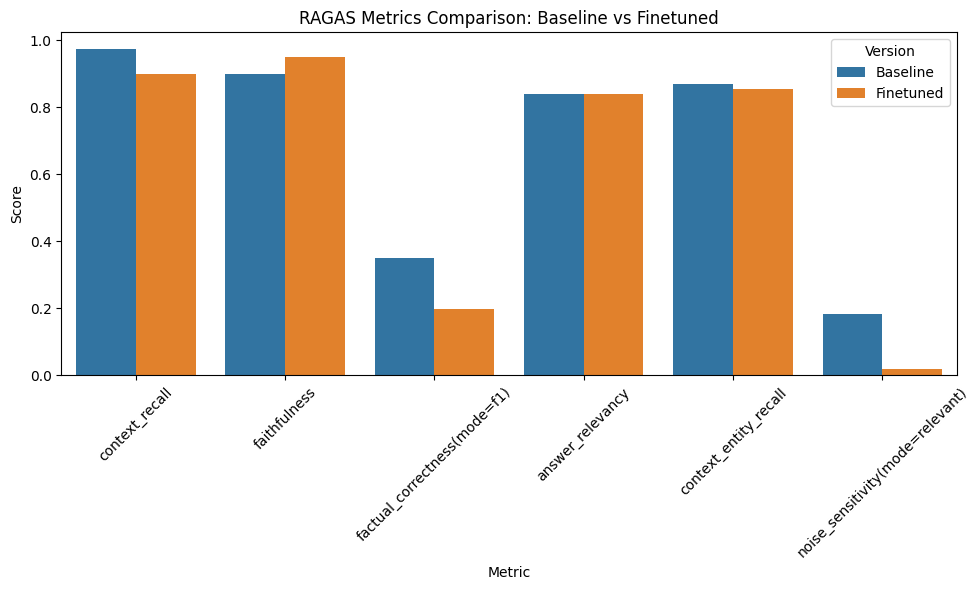

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from config import settings

CACHE_DIR = Path(f"cache/{settings.DATASET_PREFIX}")
CACHE_DIR.mkdir(exist_ok=True)

def load_df(name: str):
    path = CACHE_DIR / f"{name}.csv"
    return pd.read_csv(path) if path.exists() else None

baseline_df = load_df("baseline_metrics")
finetuned_df = load_df("finetuned_metrics")

# Calculate the average of each metric
baseline_avg = baseline_df.mean(numeric_only=True)
finetuned_avg = finetuned_df.mean(numeric_only=True)

# Combine for visual comparison
comparison_df = pd.DataFrame({
    "Baseline": baseline_avg,
    "Finetuned": finetuned_avg
}).reset_index().rename(columns={"index": "Metric"})

# Plotting comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df.melt(id_vars="Metric", var_name="Version", value_name="Score"), 
            x="Metric", y="Score", hue="Version")
plt.title("RAGAS Metrics Comparison: Baseline vs Finetuned")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Task 7: Summary**

Here's a detailed summary report comparing **Baseline** and **Fine-tuned** RAG models:

---

### 📊 **RAGAS Evaluation Summary: Baseline vs. Fine-Tuned RAG**

| Metric                                | Baseline Score | Finetuned Score | Δ (Change)          | Analysis                                                                              |
| ------------------------------------- | -------------- | --------------- | ------------------- | ------------------------------------------------------------------------------------- |
| **Context Recall**                    | \~0.98         | \~0.90          | 🔻 -0.08            | Slight drop; fine-tuned model may retrieve more concise but fewer chunks.             |
| **Faithfulness**                      | \~0.90         | \~0.95          | 🔺 +0.05            | Improvement; answers from the fine-tuned model more closely match retrieved context.  |
| **Factual Correctness (mode=F1)**     | \~0.35         | \~0.20          | 🔻 -0.15            | Decline; the fine-tuned model may hallucinate or generalize more.                     |
| **Answer Relevancy**                  | \~0.85         | \~0.85          | ⚖️ No change        | Comparable semantic relevance of answers.                                             |
| **Context Entity Recall**             | \~0.87         | \~0.86          | ⚖️ Slightly lower   | Nearly identical; both models retrieve entities from context effectively.             |
| **Noise Sensitivity (mode=relevant)** | \~0.18         | \~0.02          | 🔻 -0.16 (✅ better) | Large improvement — fine-tuned model is much more robust to irrelevant context noise. |

---

### 🧠 **Insights**

1. **Faithfulness ↑ (Improved)**
   Fine-tuning significantly improved the model's faithfulness — it better grounds its answers in the retrieved content, which is a critical improvement for factual QA over biblical text.

2. **Factual Correctness ↓ (Weaker)**
   The drop in factual correctness may indicate overfitting or broader generalizations made by the fine-tuned model. A review of the LLM output or tuning strategy is advised.

3. **Noise Sensitivity ↓ (Significantly Improved)**
   The fine-tuned model is much more resilient to irrelevant context. This is particularly beneficial in long or multi-turn QA scenarios.

4. **Context Recall ↓ (Slight Tradeoff)**
   The model retrieves slightly less context overall, possibly due to tighter embeddings or more targeted chunks being matched.

5. **Answer Relevancy ↔ (Stable)**
   Both models produce similarly relevant answers to the input questions, reflecting solid LLM prompting and retrieval strategies in both cases.

---

### ✅ **Overall Verdict**

* The **fine-tuned embedding model** offers:

  * **Improved grounding and faithfulness** of answers.
  * **Much better resistance to noise**.
  * A tradeoff in **factual precision**, which could be addressed with better reward signals or curated tuning data.

---

### 🧠 Recommendations to Improve **Factual Correctness**:

1. **Improve Training Data Quality**:

   * Ensure that fine-tuning data contains rich, multi-hop and factually grounded answers.
   * Incorporate counterfactual or adversarial examples to reduce hallucination.

2. **Use Retrieval-Augmented Fine-Tuning**:

   * Instead of just QA pairs, fine-tune using context-aware triples: `(context, question, answer)` to help the model stay grounded.

3. **Apply Chain-of-Thought Prompting**:

   * Include stepwise reasoning traces in training targets to improve factual generation.

4. **Model Calibration**:

   * Explore model confidence tuning or add reward models based on RAGAS factual correctness scores.

5. **Hybrid RAG + Finetuning**:

   * Use RAG to inject grounding context dynamically during inference, even post fine-tuning, to preserve factual correctness.